## Quick start 

### working with data
1. torch.utils.data.DataLoader(wraps an iterable around the Dataset)
2. torch.utils.data.Dataset(stores the samples and their corresponding labels)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100.0%
100.0%
100.0%
100.0%


We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels

In [ ]:
batch_size = 64 # i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating models

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

In [4]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### optimizing model parameters

To train the model we need a loss function and a optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss() # classification so cross entropy, if regression we can use regression
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # can also use ADAM

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Puts the model into training mode.
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) # calls the forward pass internally and return logits
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # Computes gradients of the loss w.r.t. all trainable parameters.
        optimizer.step() #Updates model parameters using computed gradients
        optimizer.zero_grad() # clear old gradients from prev batch, PyTorch accumulates gradients by default

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X) # loss and no of samples processed so far, len of X is nothing but batch size
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

One loop iteration does: 
1. Load a batch
2. Forward pass
3. Compute loss
4. Backpropagate gradients
5. Update weights
6. Clear gradients

Thats one training step

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # no of samples
    num_batches = len(dataloader) # no of batches
    model.eval() #Puts the model into evaluation mode.
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # no of correct predictions
    test_loss /= num_batches # loss averages over batches
    correct /= size # average correct classifications 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

correct += (pred.argmax(1) == y).type(torch.float).sum().item()

1. pred.argmax(1) -> Gets the predicted class index for each sample, dim = 1 : class dimension 
2. (pred.argmax(1) == y) -> Compares prediction with ground truth, gets a tensor True/False
3. .type(torch.float) -> Converts True → 1.0, False → 0.0
4. .sum() -> Counts correct predictions in the batch
5. .item() -> Converts to Python number and accumulates


### The Training Loop
The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302162  [   64/60000]
loss: 2.290602  [ 6464/60000]
loss: 2.277452  [12864/60000]
loss: 2.266940  [19264/60000]
loss: 2.255063  [25664/60000]
loss: 2.224659  [32064/60000]
loss: 2.228661  [38464/60000]
loss: 2.197733  [44864/60000]
loss: 2.201473  [51264/60000]
loss: 2.167671  [57664/60000]
Test Error: 
 Accuracy: 47.8%, Avg loss: 2.160590 

Epoch 2
-------------------------------
loss: 2.170949  [   64/60000]
loss: 2.158938  [ 6464/60000]
loss: 2.109317  [12864/60000]
loss: 2.126575  [19264/60000]
loss: 2.074646  [25664/60000]
loss: 2.019908  [32064/60000]
loss: 2.045814  [38464/60000]
loss: 1.972846  [44864/60000]
loss: 1.985564  [51264/60000]
loss: 1.915318  [57664/60000]
Test Error: 
 Accuracy: 60.3%, Avg loss: 1.910427 

Epoch 3
-------------------------------
loss: 1.936102  [   64/60000]
loss: 1.907700  [ 6464/60000]
loss: 1.803073  [12864/60000]
loss: 1.848778  [19264/60000]
loss: 1.724504  [25664/60000]
loss: 1.678592  [32064/600

## Save the model
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [10]:
torch.save(model.state_dict(), "FashionMNISTmodel.pth")
print("Saved PyTorch Model State to FashionMNISTmodel.pth")

Saved PyTorch Model State to FashionMNISTmodel.pth


## Loading the model 
The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("FashionMNISTmodel.pth", weights_only=True))

<All keys matched successfully>

### Make Predictions

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Pullover", Actual: "Pullover"


In [ ]:
x.shape #[1, 28, 28]   # (channels, height, width)

torch.Size([1, 28, 28])

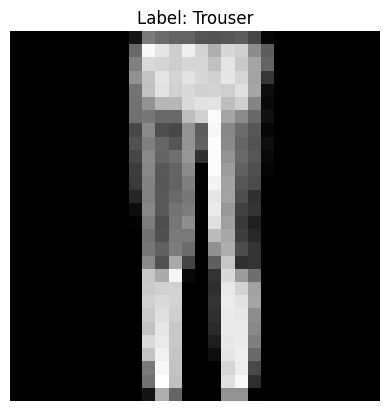

In [18]:
import matplotlib.pyplot as plt

# Get one test sample
x, y = test_data[3]

# Remove channel dimension: [1, 28, 28] -> [28, 28]
image = x.squeeze()

# Plot
plt.imshow(image, cmap="gray")
plt.title(f"Label: {classes[y]}")
plt.axis("off")
plt.show()